In [1]:
from sklearn.preprocessing import MinMaxScaler
from joblib import dump
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [2]:
def split_dataframe(
    df: pl.DataFrame,
    train_ratio: float = 0.7,
    val_ratio: float = 0.15,
    test_ratio: float = 0.15,
):
    total_rows = df.height
    train_end = int(total_rows * train_ratio)
    val_end = train_end + int(total_rows * val_ratio)

    return df.with_columns(
        pl.when(pl.arange(0, df.height) < train_end)
        .then(pl.lit("train"))
        .when(pl.arange(0, df.height) < val_end)
        .then(pl.lit("val"))
        .otherwise(pl.lit("test"))
        .alias("split_type")
    )

In [3]:
def normalization(scaler_class, df: pl.DataFrame):
    scaler_name = str(scaler_class).split(".")[-1].replace("'>", "")

    train_close = (
        df.filter(pl.col("split_type") == "train")["Monthly Mean Total Sunspot Number"]
        .to_numpy()
        .reshape(-1, 1)
    )

    scaler = scaler_class()

    scaler.fit(train_close)

    return df.with_columns(
        pl.Series(
            f"Monthly Mean Total Sunspot Number Scaled",
            scaler.transform(
                df["Monthly Mean Total Sunspot Number"].to_numpy().reshape(-1, 1)
            ).flatten(),
        )
    )

In [4]:
df = (
    pl.read_csv('../data/raw/Sunspots.csv')
        .with_columns(
            pl.col('Date')
                .str
                .to_date()
        )
)

In [14]:
len(df)

3265

In [15]:
df

,Date,Monthly Mean Total Sunspot Number,split_type,Monthly Mean Total Sunspot Number Scaled
i64,date,f64,str,f64
0,1749-01-31,96.7,"""train""",0.242843
1,1749-02-28,104.3,"""train""",0.261929
2,1749-03-31,116.7,"""train""",0.293069
3,1749-04-30,92.8,"""train""",0.233049
4,1749-05-31,141.7,"""train""",0.355851
…,…,…,…,…
3260,2020-09-30,0.6,"""test""",0.001507
3261,2020-10-31,14.4,"""test""",0.036163
3262,2020-11-30,34.0,"""test""",0.085384


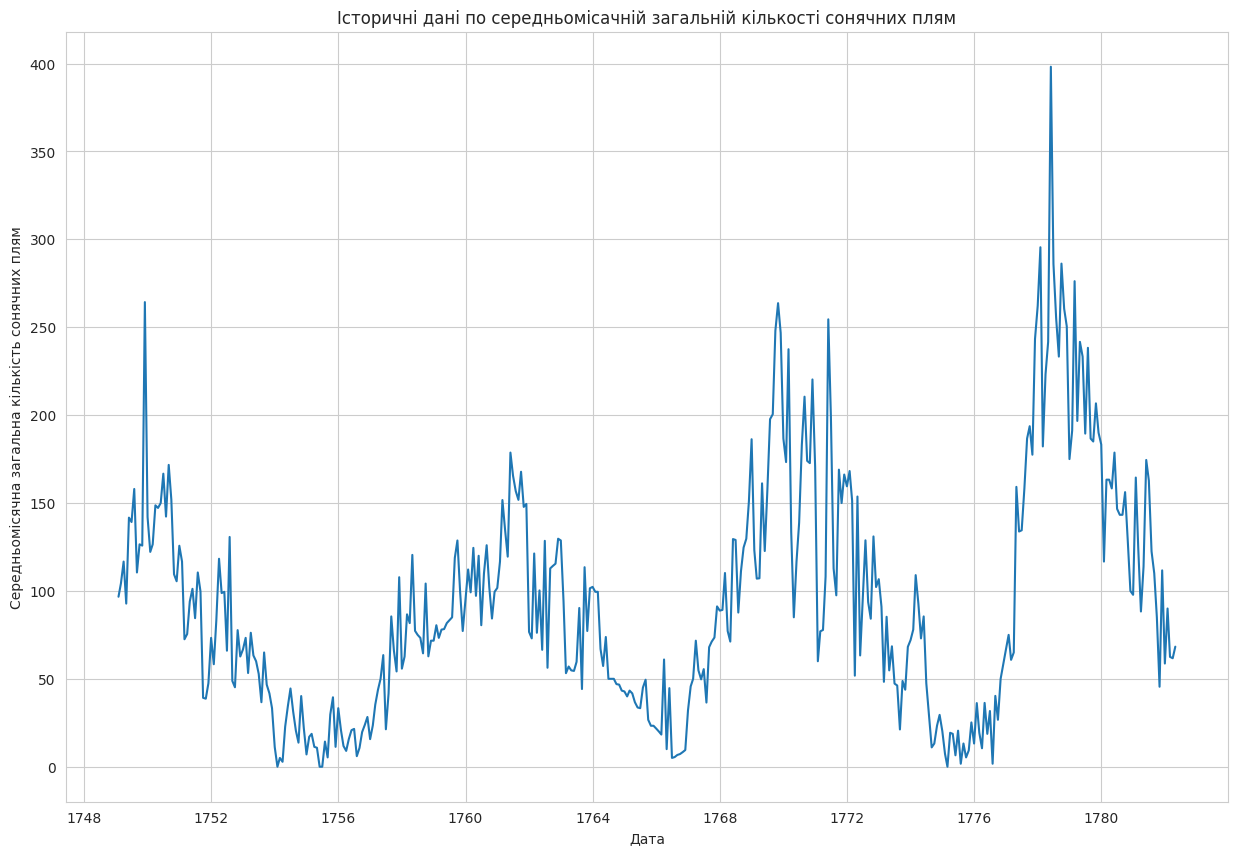

In [5]:
plt.figure(figsize=(15, 10))

sns.lineplot(data=df[:400], x="Date", y="Monthly Mean Total Sunspot Number")

plt.title('Історичні дані по середньомісачній загальній кількості сонячних плям')

plt.ylabel("Середньомісячна загальна кількість сонячних плям")

plt.xlabel("Дата")

plt.show()

In [6]:
df = split_dataframe(df)

In [7]:
df = normalization(MinMaxScaler, df)

In [8]:
df.write_csv("../data/processed/Sunspots.csv")

In [9]:
scaler = MinMaxScaler()

In [10]:
train_data = df.filter(pl.col("split_type") == "train")

In [11]:
scaler.fit(train_data["Monthly Mean Total Sunspot Number"].to_numpy().reshape(-1, 1))

MinMaxScaler()

In [12]:
dump(scaler, "../data/processed/scaler_sunspots.joblib")

['../data/processed/scaler_sunspots.joblib']